# Test Image Canonicalization Methods for Discrete Group of Transformations
In this notebook, we test the whether the group equivariant image canonicalizers can generate a canonical orientation properly for sample images. We also visualize the original and canonicalized images to see if the canonicalization is successful.

In [108]:
import torch
from torchvision import datasets, transforms
from equiadapt.images.canonicalization.discrete_group import GroupEquivariantImageCanonicalization, OptimizedGroupEquivariantImageCanonicalization
from equiadapt.images.canonicalization_networks import ESCNNEquivariantNetwork, ConvNetwork
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from tqdm import tqdm

## Load the CIFAR-10 dataset
First load the dataset and the dataloader.

In [109]:
# Load the CIFAR10 dataset
train_transform = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.Resize(64),

                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(5),

                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                ])

test_transform = transforms.Compose([
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
            ])

# to visualize the original images
invert_normalize = transforms.Compose([
                transforms.Normalize(mean=(-0.4914/0.247, -0.4822/0.243, -0.4465/0.261), 
                                     std=(1/0.247, 1/0.243, 1/0.261)),
            ])

data_path = "/home/mila/s/siba-smarak.panigrahi/scratch/equiadapt_expts/image/data/cifar10"
train_dataset = datasets.CIFAR10(root=data_path, train=True, download=False, transform=train_transform)
test_dataset = datasets.CIFAR10(root=data_path, train=False, download=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Visulize the original images.

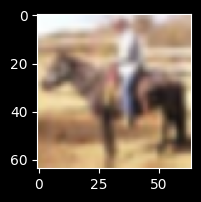

In [110]:
sample_data = next(iter(test_loader))

# Visualize the original image that is sample to test canonicalization
sample_image = invert_normalize(sample_data[0][0]).permute(1, 2, 0).numpy()

plt.figure(figsize=(2, 2))
plt.imshow(sample_image)
plt.show()

Function to visualize a list of image tensors.

In [111]:
def plot_image_tensors(image_tensors, titles=None, figsize=(4, 4)):
    """
    Plots a list of image tensors in a grid.

    Parameters:
    - image_tensors: List[Tensor]. A list of image tensors in (C, H, W) format.
    - titles: List[str]. Optional. A list of titles for each subplot.
    - figsize: tuple. The figure size.
    """
    # Determine the number of images
    num_images = len(image_tensors)

    # Calculate grid size for the subplots
    rows = int(torch.sqrt(torch.tensor(num_images)).item())
    cols = (num_images + rows - 1) // rows  # Ensure enough columns to display all images

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easy iteration, in case of a single row/column
    axes = axes.flatten()

    # Loop through all the images and their corresponding axes
    for i, (img_tensor, ax) in enumerate(zip(image_tensors, axes)):
        # Convert the tensor for visualization
        img_np = invert_normalize(img_tensor.squeeze()).permute(1, 2, 0).numpy()
        
        # Plot the image
        ax.imshow(img_np)
        ax.axis('off')  # Hide the axis

        # Set title if titles are provided
        if titles and i < len(titles):
            ax.set_title(titles[i])

    # If there are more axes than images, hide the extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Check canonicalization for Ck group

We first test it for C4 which is a group of k discrete rotations.

For this we first transform the image to k uniformly spaced rotations and then apply the canonicalization to the image. 

We then check if the canonicalized image is the same as the original image.

In [112]:
# Transform the image using k random rotations
# number of random rotations
k = 4
# Original tensor image from the DataLoader
sample_image_tensor = sample_data[0][0]  # Assuming the first item is your image tensor

# Define an empty list to store the transformed tensor images
transformed_sample_images = []

# Get the shape of the image tensor
h, w = sample_image_tensor.shape[-2:]

# Pad the image to get rid of the black borders
pad = transforms.Pad(10, padding_mode='edge')

# crop the image to get rid of the black borders
crop = transforms.CenterCrop((h, w))
# Loop over the number of random rotations
# and transform the image tensor using torch rotation
for i in range(k):
    # Generate a random angle for rotation
    angle = (360/k) * i
    
    # Pad the image to get rid of the black borders
    padded_image_tensor = pad(sample_image_tensor)
    
    # Apply the rotation to the tensor
    transformed_image_tensor = F.rotate(padded_image_tensor, angle)
    
    # Add the transformed tensor to the list
    transformed_sample_images.append(crop(transformed_image_tensor))



Visualize the transformed images

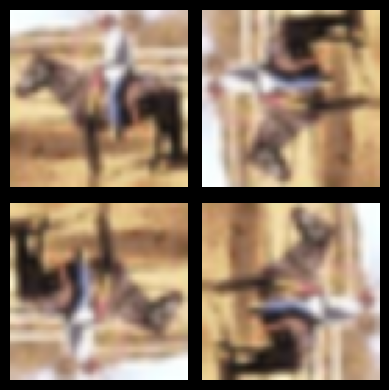

In [113]:
# Visualizing all the transformed images 
plot_image_tensors(transformed_sample_images)

Function to plot canonicalized images

In [114]:
def get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer): 
    # Set the canonicalizer to evaluation mode
    canonicalizer.eval()
    
    # Get canonicalized images for all transformed images
    with torch.no_grad():
        canonicalized_images = []
        for im in transformed_sample_images:
            im = im.unsqueeze(0).to(device)
            canonicalized_image = canonicalizer.canonicalize(im)
            canonicalized_images.append(canonicalized_image.detach().cpu())

    # Visualizing all the canonicalized images
    plot_image_tensors(canonicalized_images)

### Check for canonicalization for the group equivariant image canonicalizers

Define a group equivariant canonicalization network and a GroupEquivariantImageCanonicalization object.

In [115]:
# Define the hyperparameters for the canonicalization network
class CanonicalizationHyperparams:
    def __init__(self):
        self.input_crop_ratio = 0.9 # The ratio of the input image to crop
        self.beta = 1.0 # Beta parameter for the canonization network
        self.resize_shape = 64 # The shape of the image after resizing

# Create an instance of the hyperparameters
canonicalization_hyperparams = CanonicalizationHyperparams()

# Get the shape of the image
image_shape = sample_image_tensor.squeeze().shape

# Print the image shape
print(f"Image shape: {image_shape}")

# Define a steerable canonicalization network
# Note that you define any steerable network here as long as it outputs 
# a vector that steers with the input image
# This vector is used to get a rotation matrix in a differentiable manner 
canonicalization_network = ESCNNEquivariantNetwork(
    in_shape = image_shape,
    out_channels=16, 
    kernel_size= 9, 
    num_layers = 3,
    group_type='rotation', 
    num_rotations=4, 
).to(device)


# Create a steerable canonicalization object
canonicalizer = GroupEquivariantImageCanonicalization(
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=canonicalization_hyperparams,
    in_shape=image_shape,
)


Image shape: torch.Size([3, 64, 64])


Canonicalize all the transformed images and visualize the canonicalized images.

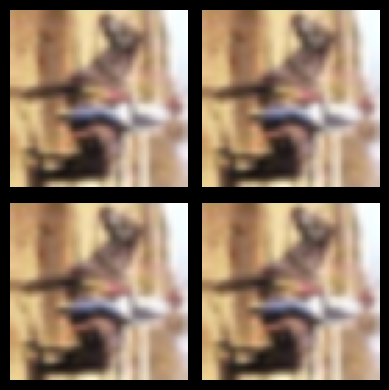

In [116]:
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

Now train the canonicalizer using prior regularization to get identity canonical orientation for original images.

In [117]:
# Train the canonicalization network using prior regularization

# Define the optimizer
optimizer = torch.optim.Adam(canonicalization_network.parameters(), lr=0.002)

# Set the canonicalizer to training mode
canonicalizer.train()

# Set a weight for the prior regularization loss
prior_regularization_weight = 100

# Define the training loop
num_epochs = 15
for epoch in range(num_epochs):
    # Initialize tqdm with an initial description
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    identity_metric = 0
    total_loss = 0  # To track the total loss for averaging
    
    for image, _ in train_loader_tqdm:
        # Zero the gradients
        optimizer.zero_grad()
        
        image = image.to(device)
        canonicalized_image = canonicalizer.canonicalize(image)
        
        # Get the prior regularization loss
        loss = prior_regularization_weight * canonicalizer.get_prior_regularization_loss()
        
        # Backpropagate the gradients
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update the running average of identity metric
        identity_metric += canonicalizer.get_identity_metric()

        # Update total loss for averaging
        total_loss += loss.item()

        # Update tqdm description with current loss (average loss per batch)
        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/(train_loader_tqdm.n + 1):.4f}")
    
    # Calculate and print the average loss and identity metric over the epoch
    avg_loss = total_loss / len(train_loader)
    identity_metric /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Identity Metric: {identity_metric:.4f}")    
    
    

Epoch 1/15, Loss: 111.8979: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


Epoch 1/15, Average Loss: 111.8979, Identity Metric: 0.5239


Epoch 2/15, Loss: 100.2526: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


Epoch 2/15, Average Loss: 100.2526, Identity Metric: 0.5811


Epoch 3/15, Loss: 93.5566: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


Epoch 3/15, Average Loss: 93.5566, Identity Metric: 0.6123


Epoch 4/15, Loss: 89.6447: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]


Epoch 4/15, Average Loss: 89.6447, Identity Metric: 0.6313


Epoch 5/15, Loss: 86.7159: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s]


Epoch 5/15, Average Loss: 86.7159, Identity Metric: 0.6454


Epoch 6/15, Loss: 84.9778: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


Epoch 6/15, Average Loss: 84.9778, Identity Metric: 0.6532


Epoch 7/15, Loss: 83.2758: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]


Epoch 7/15, Average Loss: 83.2758, Identity Metric: 0.6609


Epoch 8/15, Loss: 82.1156: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


Epoch 8/15, Average Loss: 82.1156, Identity Metric: 0.6671


Epoch 9/15, Loss: 81.4681: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


Epoch 9/15, Average Loss: 81.4681, Identity Metric: 0.6709


Epoch 10/15, Loss: 80.3081: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


Epoch 10/15, Average Loss: 80.3081, Identity Metric: 0.6776


Epoch 11/15, Loss: 79.3386: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]


Epoch 11/15, Average Loss: 79.3386, Identity Metric: 0.6798


Epoch 12/15, Loss: 78.5606: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


Epoch 12/15, Average Loss: 78.5606, Identity Metric: 0.6859


Epoch 13/15, Loss: 78.3811: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]


Epoch 13/15, Average Loss: 78.3811, Identity Metric: 0.6867


Epoch 14/15, Loss: 77.8446: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]


Epoch 14/15, Average Loss: 77.8446, Identity Metric: 0.6886


Epoch 15/15, Loss: 77.4739: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]

Epoch 15/15, Average Loss: 77.4739, Identity Metric: 0.6897


Canonicalize all the transformed images and visualize them after prior regularization.

The canonicalization network is able to generate the canonical orientation which are in the training data distribution.

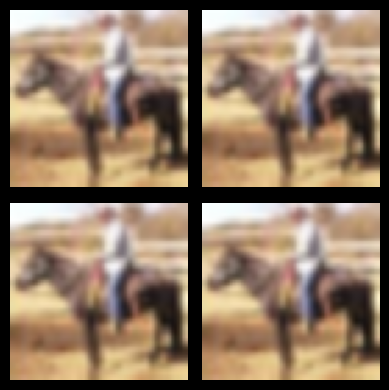

In [118]:
# Visualize the canonicalized images after training the canonicalization network using prior regularization
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

### Check canonicalization using the optimization based method for discrete groups

Define a non-equivariant canonicalization network that outputs a vector which will be used to compute energy/activations.

Then define a OptimizedGroupEquivariantImageCanonicalization object which will provide us with methods to optimize for correct canonical orientation.

In [121]:
# Define the hyperparameters for the canonicalization network
class CanonicalizationHyperparams:
    def __init__(self):
        self.group_type = "rotation" # Type of group for the canonization network
        self.num_rotations = 4
        self.input_crop_ratio = 0.9 # The ratio of the input image to crop
        self.beta = 1.0 # Beta parameter for the canonization network
        self.resize_shape = 64 # The shape of the image after resizing
        self.artifact_weight = 1000 # The weight for the artifact error loss
        self.learn_ref_vec = False # Whether to learn the reference vector
        
# Create an instance of the hyperparameters
canonicalization_hyperparams = CanonicalizationHyperparams()

# Get the shape of the image
image_shape = sample_image_tensor.squeeze().shape

# Print the image shape
print(f"Image shape: {image_shape}")

# Define a steerable canonicalization network
# Note that you define any steerable network here as long as it outputs 
# a vector that steers with the input image
# This vector is used to get a rotation matrix in a differentiable manner 
canonicalization_network = ConvNetwork(
    in_shape = image_shape,
    out_channels=16, 
    kernel_size= 5, 
    num_layers = 3,
    out_vector_size=128,
).to(device)


# Create a steerable canonicalization object
canonicalizer = OptimizedGroupEquivariantImageCanonicalization(
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=canonicalization_hyperparams,
    in_shape=image_shape,
).to(device)

Image shape: torch.Size([3, 64, 64])


Canonicalize all the transformed images and visualize the canonicalized images using untrained canonicalization network.

Note that the canonicalization is not successful as the canonicalization network is not trained and outputs similar energies for different orientations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


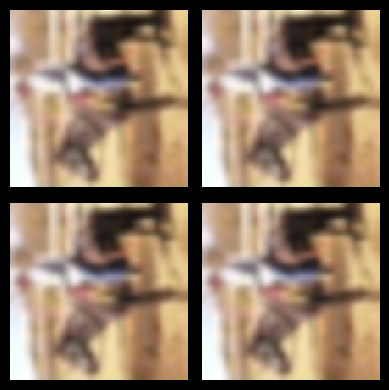

In [122]:
# Visualize the canonicalized images before training the canonicalization network using optimization method
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

Now we train the canonicalization network using optimization based method which enforces different energies for different orientations.

Moreover we also use prior regularization to get identity canonical orientation for original images.

In [123]:
# Train the canonicalization network using prior regularization and optimization specific loss

# Define the optimizer
optimizer = torch.optim.Adam(canonicalization_network.parameters(), lr=0.002)

# Set the canonicalizer to training mode
canonicalizer.train()

# Set weights for the losses
prior_regularization_weight = 100
optimization_specific_loss_weight = 0.1

# Define the training loop
num_epochs = 15
for epoch in range(num_epochs):
    # Initialize tqdm with an initial description
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    identity_metric = 0
    total_prior_loss = 0  # To track the total prior regularization loss for averaging
    total_optimization_specific_loss = 0  # To track the total optimization specific loss for averaging
    
    for image, _ in train_loader_tqdm:
        # Zero the gradients
        optimizer.zero_grad()
        
        image = image.to(device)
        canonicalized_image = canonicalizer.canonicalize(image)
        
        # Get the prior regularization loss
        prior_loss = canonicalizer.get_prior_regularization_loss()
        
        # Get the optimization specific loss
        optimization_specific_loss = canonicalizer.get_optimization_specific_loss()
        
        # Combine the losses
        loss = prior_regularization_weight * prior_loss + optimization_specific_loss_weight * optimization_specific_loss
        
        # Backpropagate the gradients
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update the running average of identity metric and loss totals
        identity_metric += canonicalizer.get_identity_metric()
        total_prior_loss += prior_loss.item()
        total_optimization_specific_loss += optimization_specific_loss.item()

        # Update tqdm description with current losses
        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}, \
                                          Prior Loss: {total_prior_loss/(train_loader_tqdm.n + 1):.4f}, \
                                          Opt Loss: {total_optimization_specific_loss/(train_loader_tqdm.n + 1):.4f}")
    
    # Calculate and print the average losses and identity metric over the epoch
    avg_prior_loss = total_prior_loss / len(train_loader)
    avg_optimization_specific_loss = total_optimization_specific_loss / len(train_loader)
    identity_metric /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Prior Loss: {avg_prior_loss:.4f}, \
          Avg Opt Loss: {avg_optimization_specific_loss:.4f}, Identity Metric: {identity_metric:.4f}")

   

Epoch 1/15,                                           Prior Loss: 1.2988,                                           Opt Loss: 91.6631: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s] 


Epoch 1/15, Avg Prior Loss: 1.2988,           Avg Opt Loss: 91.6631, Identity Metric: 0.5572


Epoch 2/15,                                           Prior Loss: 1.2646,                                           Opt Loss: 35.1493: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Epoch 2/15, Avg Prior Loss: 1.2646,           Avg Opt Loss: 35.1493, Identity Metric: 0.5910


Epoch 3/15,                                           Prior Loss: 1.2456,                                           Opt Loss: 31.1135: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Epoch 3/15, Avg Prior Loss: 1.2456,           Avg Opt Loss: 31.1135, Identity Metric: 0.6123


Epoch 4/15,                                           Prior Loss: 1.2385,                                           Opt Loss: 31.8964: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Epoch 4/15, Avg Prior Loss: 1.2385,           Avg Opt Loss: 31.8964, Identity Metric: 0.6195


Epoch 5/15,                                           Prior Loss: 1.2304,                                           Opt Loss: 29.7583: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Epoch 5/15, Avg Prior Loss: 1.2304,           Avg Opt Loss: 29.7583, Identity Metric: 0.6251


Epoch 6/15,                                           Prior Loss: 1.2195,                                           Opt Loss: 26.1346: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Epoch 6/15, Avg Prior Loss: 1.2195,           Avg Opt Loss: 26.1346, Identity Metric: 0.6416


Epoch 7/15,                                           Prior Loss: 1.2135,                                           Opt Loss: 25.5342: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]


Epoch 7/15, Avg Prior Loss: 1.2135,           Avg Opt Loss: 25.5342, Identity Metric: 0.6461


Epoch 8/15,                                           Prior Loss: 1.2069,                                           Opt Loss: 23.3951: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Epoch 8/15, Avg Prior Loss: 1.2069,           Avg Opt Loss: 23.3951, Identity Metric: 0.6523


Epoch 9/15,                                           Prior Loss: 1.2046,                                           Opt Loss: 20.9949: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Epoch 9/15, Avg Prior Loss: 1.2046,           Avg Opt Loss: 20.9949, Identity Metric: 0.6530


Epoch 10/15,                                           Prior Loss: 1.2015,                                           Opt Loss: 21.3232: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Epoch 10/15, Avg Prior Loss: 1.2015,           Avg Opt Loss: 21.3232, Identity Metric: 0.6552


Epoch 11/15,                                           Prior Loss: 1.1928,                                           Opt Loss: 18.0174: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


Epoch 11/15, Avg Prior Loss: 1.1928,           Avg Opt Loss: 18.0174, Identity Metric: 0.6643


Epoch 12/15,                                           Prior Loss: 1.1921,                                           Opt Loss: 18.9864: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Epoch 12/15, Avg Prior Loss: 1.1921,           Avg Opt Loss: 18.9864, Identity Metric: 0.6662


Epoch 13/15,                                           Prior Loss: 1.1856,                                           Opt Loss: 15.7955: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Epoch 13/15, Avg Prior Loss: 1.1856,           Avg Opt Loss: 15.7955, Identity Metric: 0.6702


Epoch 14/15,                                           Prior Loss: 1.1849,                                           Opt Loss: 15.9456: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]


Epoch 14/15, Avg Prior Loss: 1.1849,           Avg Opt Loss: 15.9456, Identity Metric: 0.6740


Epoch 15/15,                                           Prior Loss: 1.1838,                                           Opt Loss: 13.6234: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]

Epoch 15/15, Avg Prior Loss: 1.1838,           Avg Opt Loss: 13.6234, Identity Metric: 0.6774


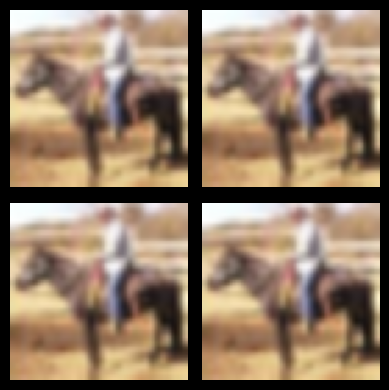

In [124]:
# Visualize the canonicalized images after training the canonicalization network using optimization method and prior regularization
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)